In [1]:
import json
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [7]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    padding = [pad_token] * window
    tokens = padding + tokens + padding
    for i in range(window, len(tokens)-window):
        splits.append([tokens[i-window:i], tokens[i], tokens[i+1:i+window+1]])
        
    return splits

In [8]:
splits = cbow_split(sample_text, window=2)

In [9]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']

Левый контекст: ['денежный', 'средство']
Центральное слово: лицевой
Правый контекст: ['счёт', 'либо']

Левый контекст: ['средство', 'лицевой']
Центральное слово: счёт
Правый контекст: ['либо', 'зачесть']

Левый контекст: ['лицевой', 'счёт']
Центральное слово: либо
Правый контекст: ['зачесть', 'счёт']

Левый контекст: ['счёт', 'либо']
Центральное слово: зачесть
Правый контекст: ['счёт', 'погашение']

Левый контекст: ['либо', 'зачесть']
Центральное слово: счёт
Правый контекст: ['погашение', 'кредит']

Левый контекст: ['зачесть', 'счёт']
Центральное слово: погашение
Правый контекст: ['кредит', 'PAD']

Левый контекст: ['счёт', 'погашение']
Центральное слово: кредит
Правый контекст: [

In [10]:
splits

[[['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']],
 [['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']],
 [['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']],
 [['денежный', 'средство'], 'лицевой', ['счёт', 'либо']],
 [['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']],
 [['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']],
 [['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']],
 [['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']],
 [['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']],
 [['счёт', 'погашение'], 'кредит', ['PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [11]:
cbow_split(sample_text, window=3)

[[['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']],
 [['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']],
 [['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']],
 [['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']],
 [['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']],
 [['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']],
 [['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']],
 [['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']],
 [['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']],
 [['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [12]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом Skipgram

In [13]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for i in range(len(tokens)):
        for j in range(i-window, i+window+1):
            if i != j and j >= 0 and j < len(tokens):
                splits.append((tokens[j], tokens[i]))
        
    return splits

In [14]:
splits = skipgram_split(sample_text, window=2)

In [15]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный

Контекст: средство
Центральное слово: денежный

Контекст: лицевой
Центральное слово: денежный

Контекст: вернуть
Центральное слово: средство

Контекст: денежный
Центральное слово: средство

Контекст: лицевой
Центральное слово: средство

Контекст: счёт
Центральное слово: средство

Контекст: денежный
Центральное слово: лицевой

Контекст: средство
Центральное слово: лицевой

Контекст: счёт
Центральное слово: лицевой

Контекст: либо
Центральное слово: лицевой

Контекст: средство
Центральное слово: счёт

Контекст: лицевой
Центральное слово: счёт

Контекст: либо
Центральное слово: счёт

Контекст: зачесть
Центральное слово: счёт

Контекст: лицевой
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: зачесть
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: счёт
Центральное слово: зачесть

Контекст: либо
Цент

In [16]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('зачесть', 'погашение'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('счёт', 'кредит'),
 ('погашение', 'кредит')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [17]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('вернуть', 'лицевой'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('денежный', 'счёт'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('средство', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('погашение', 'либо'),
 ('лицевой', 'зачесть'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('кредит', 'зачесть'),
 ('счёт', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('либо', 'погашение'),
 ('зачесть', 'погашени

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [18]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [19]:
len(word2index)

13076

In [20]:
word2index['UNK']

1

In [21]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [24]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.26366507, 0.16449326, 0.15924715, 0.14821582],
       [0.57034614, 0.26683211, 0.58771715, 0.52630457],
       [0.10330124, 0.7848989 , 0.00114277, 0.14163836],
       [0.60140353, 0.07230652, 0.74256792, 0.22497495],
       [0.8237289 , 0.2854647 , 0.73542375, 0.99686398],
       [0.3609755 , 0.51142498, 0.0466525 , 0.19388696],
       [0.18098948, 0.8683145 , 0.16492983, 0.44012425],
       [0.30299337, 0.7196201 , 0.60521628, 0.91340991],
       [0.11271028, 0.40627454, 0.2312536 , 0.42536498],
       [0.42227701, 0.70650851, 0.0753262 , 0.95029544]])

In [25]:
some_data_y

array([2, 1, 2, ..., 0, 2, 1])

In [26]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [27]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [28]:
some_dataset[5], some_dataset[467]

((array([0.3609755 , 0.51142498, 0.0466525 , 0.19388696]), 2),
 (array([0.83624985, 0.68475691, 0.91898488, 0.51019293]), 0))

In [29]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [30]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.2008, 0.8768, 0.9119, 0.0158],
         [0.3770, 0.8117, 0.3138, 0.5328],
         [0.2971, 0.7273, 0.4738, 0.4257],
         [0.5513, 0.3340, 0.4243, 0.4212],
         [0.9738, 0.6577, 0.6515, 0.5841],
         [0.9798, 0.1058, 0.7044, 0.7063],
         [0.3324, 0.7710, 0.5878, 0.6738],
         [0.3323, 0.6085, 0.8247, 0.7689],
         [0.4846, 0.0151, 0.7764, 0.9464],
         [0.7540, 0.9304, 0.8715, 0.5284],
         [0.9132, 0.8178, 0.5663, 0.4889],
         [0.5542, 0.3156, 0.8404, 0.1375],
         [0.5647, 0.6950, 0.6197, 0.6861],
         [0.7849, 0.3540, 0.6437, 0.2231],
         [0.1825, 0.5391, 0.0448, 0.8947],
         [0.0214, 0.3647, 0.3213, 0.0983]], dtype=torch.float64))

In [31]:
for x, y in some_loader:
    pass

len(x)

15

In [32]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [33]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [34]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [35]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [36]:
for x, y in toy_loader:
    break

In [37]:
x.shape

torch.Size([128, 32])

In [38]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 2.6367e-01,  1.6449e-01,  1.5925e-01,  ..., -1.0829e+01,
         -1.1024e+01, -1.1455e+01],
        [ 5.7035e-01,  2.6683e-01,  5.8772e-01,  ..., -7.9268e+00,
         -3.1891e+00, -3.8513e+00],
        [ 1.0330e-01,  7.8490e-01,  1.1428e-03,  ..., -1.4532e+00,
         -4.0646e+01, -1.1727e+01],
        ...,
        [ 5.6967e-01,  8.8411e-01,  9.7401e-01,  ..., -7.3907e-01,
         -1.5799e-01, -1.9122e+00],
        [ 1.6571e-01,  2.0310e-01,  1.5520e-01,  ..., -9.5645e+00,
         -1.1178e+01, -1.2074e+00],
        [ 1.9376e-01,  8.3106e-01,  4.8108e-01,  ..., -1.1103e+00,
         -4.3903e+00, -4.5343e+01]], dtype=torch.float64)

In [39]:
y

tensor([2, 1, 2, 0, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 0, 1, 2, 2, 2,
        1, 1, 2, 2, 1, 2, 1, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2,
        0, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 2, 1, 0, 0,
        2, 2, 0, 2, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 2, 0, 1, 0, 2, 0,
        2, 2, 0, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [40]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [41]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.131593108177185

# Боевые датасеты

In [42]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

In [43]:
cbow_dataset = CBOWDataset(corpus, word2index)

 49%|████▉     | 49095/100000 [00:01<00:01, 28672.84it/s]

100%|██████████| 100000/100000 [00:02<00:00, 33868.86it/s]


In [44]:
for i in range(10):
    print(cbow_dataset[i])

(tensor([13076, 13076,     1,     2]), 0)
(tensor([13076,     0,     2,     3]), 1)
(tensor([0, 1, 3, 4]), 2)
(tensor([1, 2, 4, 5]), 3)
(tensor([2, 3, 5, 6]), 4)
(tensor([3, 4, 6, 7]), 5)
(tensor([    4,     5,     7, 13076]), 6)
(tensor([    5,     6, 13076, 13076]), 7)
(tensor([13076, 13076,     9,    10]), 8)
(tensor([13076,     8,    10,    11]), 9)


# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [45]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
from word2vec_utils import SkipgramDataset

In [46]:
dataset = SkipgramDataset(corpus, word2index)

  8%|▊         | 8440/100000 [00:00<00:01, 84386.40it/s]

100%|██████████| 100000/100000 [00:01<00:00, 94415.91it/s]


In [47]:
for i in range(10):
    print(dataset[i])

(1, 0)
(2, 0)
(0, 1)
(2, 1)
(3, 1)
(0, 2)
(1, 2)
(3, 2)
(4, 2)
(1, 3)


In [48]:
BATCH_SIZE = 512

In [49]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [50]:
for x, y in dataset_loader:
    break

In [51]:
x[:5]

tensor([8219, 1508,  190, 1964,   25])

In [52]:
y[:5]

tensor([1590, 2445, 3276, 1151,  236])

In [53]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [54]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [55]:
from word2vec_utils import SkipGram

In [56]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [57]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [58]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [59]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0003)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [60]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            optimizer.zero_grad()
            pred = model(x)

            loss = criterion(pred, y)
            
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [02:50<00:00, 17499.06it/s, loss=7.07]


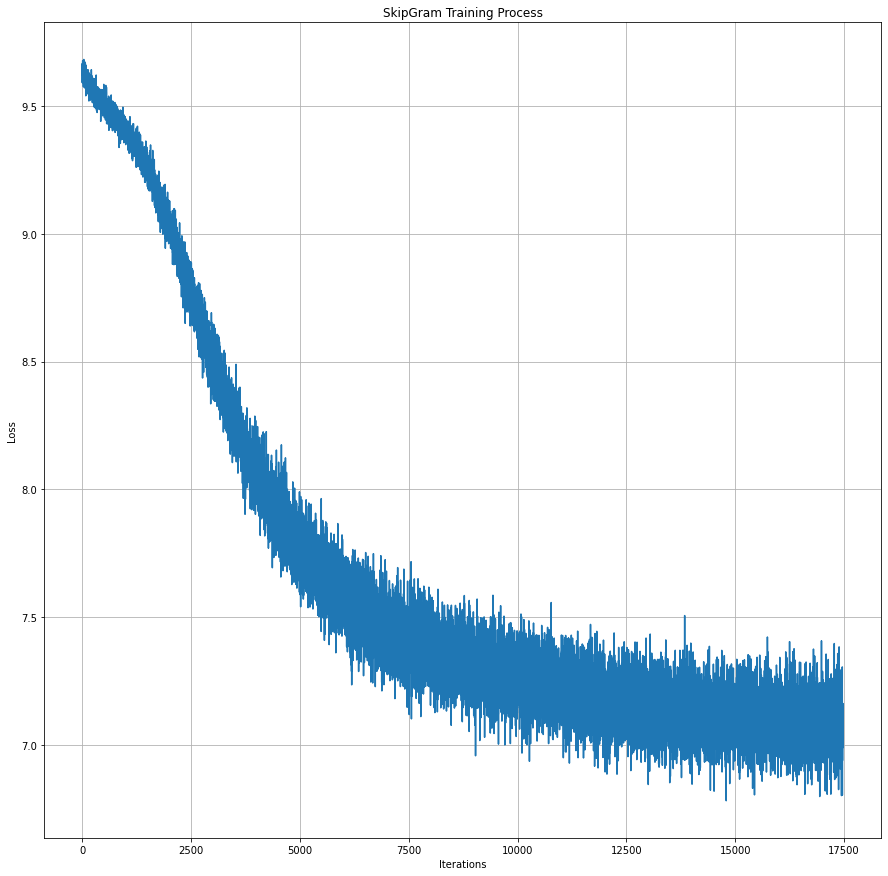

In [61]:
plt.title('SkipGram Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [62]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [63]:
embedding_matrix = model.in_embedding.weight.detach()

In [64]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1] if word1 in token2id else token2id['UNK']
    i2 = token2id[word2] if word2 in token2id else token2id['UNK']
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

от 0 до 1 - это для векторов частотностей, где все значения неотрицательные

для эмбеддингов от -1 до 1:

In [65]:
example_tensor = torch.rand(EMBEDDING_DIM)
normalized_tensor = example_tensor.div(example_tensor.norm(keepdim=True))
print('Cosine similarity with itself:', torch.dot(normalized_tensor, normalized_tensor).item())
print('Cosine similarity with opposite:', torch.dot(normalized_tensor, -normalized_tensor).item())

Cosine similarity with itself: 1.0
Cosine similarity with opposite: -1.0


In [66]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.3972795903682709

In [67]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.45411407947540283

In [68]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.1441923975944519

In [69]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.17632251977920532

In [70]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "неуважительно" равна -0.150'

In [71]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [72]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [73]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.001s...
[t-SNE] Computed neighbors for 13076 samples in 0.445s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076


[t-SNE] Computed conditional probabilities for sample 13000 / 13076
[t-SNE] Computed conditional probabilities for sample 13076 / 13076
[t-SNE] Mean sigma: 1.203847
[t-SNE] Computed conditional probabilities in 0.241s
[t-SNE] Iteration 50: error = 98.8200073, gradient norm = 0.0000000 (50 iterations in 1.838s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 98.820007
[t-SNE] Iteration 100: error = 5.7192874, gradient norm = 0.0343027 (50 iterations in 1.777s)
[t-SNE] Iteration 150: error = 4.9298735, gradient norm = 0.0043149 (50 iterations in 1.532s)
[t-SNE] Iteration 200: error = 4.8326073, gradient norm = 0.0048746 (50 iterations in 1.700s)
[t-SNE] Iteration 250: error = 4.7572885, gradient norm = 0.0049791 (50 iterations in 1.407s)
[t-SNE] Iteration 300: error = 4.6980324, gradient norm = 0.0051653 (50 iterations in 1.458s)
[t-SNE] Iteration 350: error = 4.6500702, gradient norm = 0.0051775 (50 iterations in

In [74]:
top_words = [a for a,_ in top_sorted_freq]

In [75]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

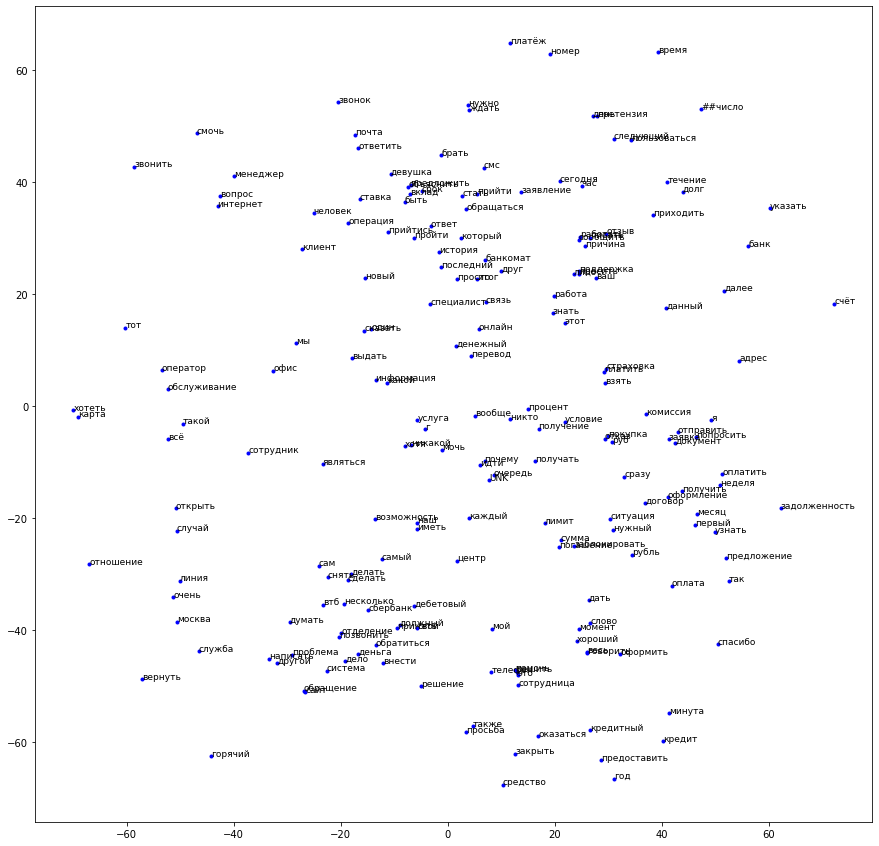

In [76]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

Читаем датасет из .tsv файла

In [77]:
df_eval = pd.read_csv('data/ru_simlex965_tagged.tsv', sep='\t')
df_eval.head()

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23


Убираем POS-теги и нормализуем значения столбца Average Score в [-1, 1]

In [78]:
df_eval = df_eval.rename(columns={'# Word1': 'Word1'})

df_eval['Word1'] = df_eval['Word1'].apply(lambda x: x.split('_')[0])
df_eval['Word2'] = df_eval['Word2'].apply(lambda x: x.split('_')[0])

max_score = df_eval['Average Score'].max()
min_score = df_eval['Average Score'].min()

# нормализация от -1 до 1
df_eval['Average Score'] = df_eval['Average Score'].apply(lambda x: -1 + (2*((x - min_score) / (max_score - min_score))))
df_eval.head()

,Word1,Word2,Average Score
0,авария,бедствие,0.230
1,август,месяц,-0.430
2,авиация,полет,0.354
3,автомобиль,гудок,-0.630
4,автомобиль,автострада,-0.754


Функция для подсчета косинусной близости каждой из пар слов в датафрейме и вычисления MSE

In [79]:
def calculate_mse(embedding_matrix):
    df_eval['word2vec score'] = df_eval.apply(lambda row: cos_sim(
        embedding_matrix, word2index, row['Word1'], row['Word2']
    ), axis=1)

    print('MSE:', mean_squared_error(df_eval['Average Score'], df_eval['word2vec score']))

MSE на исходной матрице эмбеддингов

In [80]:
calculate_mse(embedding_matrix)

MSE: 0.7569283910671823


In [81]:
df_eval.head()

,Word1,Word2,Average Score,word2vec score
0,авария,бедствие,0.230,0.109787
1,август,месяц,-0.430,0.389986
2,авиация,полет,0.354,1.000000
3,автомобиль,гудок,-0.630,-0.080580
4,автомобиль,автострада,-0.754,0.201626


Функция для всего пайплайна обучения

In [82]:
def train(window=2, batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM, lr=0.0003, epochs=3):

    dataset = SkipgramDataset(corpus, word2index, window=window)
    dataset_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

    model = SkipGram(vocab_size=len(word2index), embedding_dim=embedding_dim)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    losses = []

    for n_epoch in range(epochs):

        try:
            
            progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

            for x, y in dataset_loader:

                optimizer.zero_grad()
                pred = model(x)

                loss = criterion(pred, y)
                
                loss.backward()
                optimizer.step()
                
                losses.append(loss.item())
                
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            progress_bar.close()

        except KeyboardInterrupt:

            progress_bar.close()
            break

    plt.title('SkipGram Training Process')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    plt.plot(losses)

    embedding_matrix = model.in_embedding.weight.detach()

    return embedding_matrix   

## Эксперимент 2

Возьмем размер эмбеддингов 30 вместо 20.

 27%|██▋       | 26705/100000 [00:00<00:00, 89465.15it/s]

Epoch 3: 100%|██████████| 2983124/2983124 [02:57<00:00, 16827.16it/s, loss=7.02]


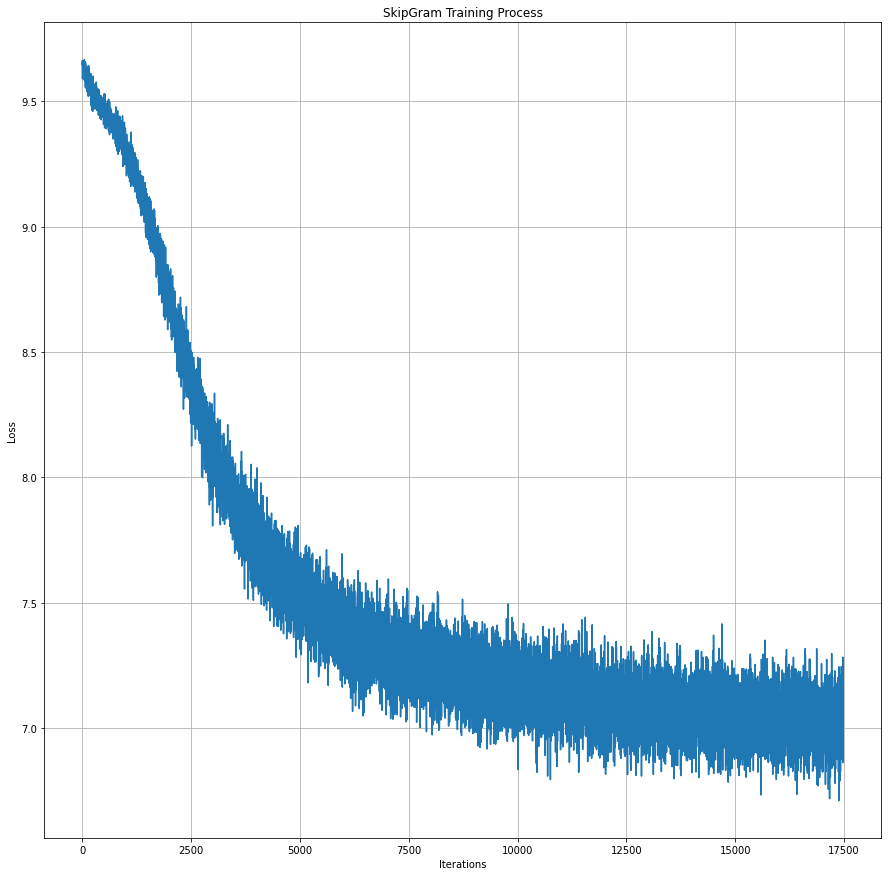

In [83]:
embedding_matrix_2 = train(embedding_dim=30)

In [84]:
calculate_mse(embedding_matrix_2)

MSE: 0.7314246298386959


MSE уменьшился, качество улучшилось!

## Эксперимент 3

Увеличим learning_rate до 0.001.

Epoch 3: 100%|██████████| 2983124/2983124 [02:58<00:00, 16726.44it/s, loss=6.82]


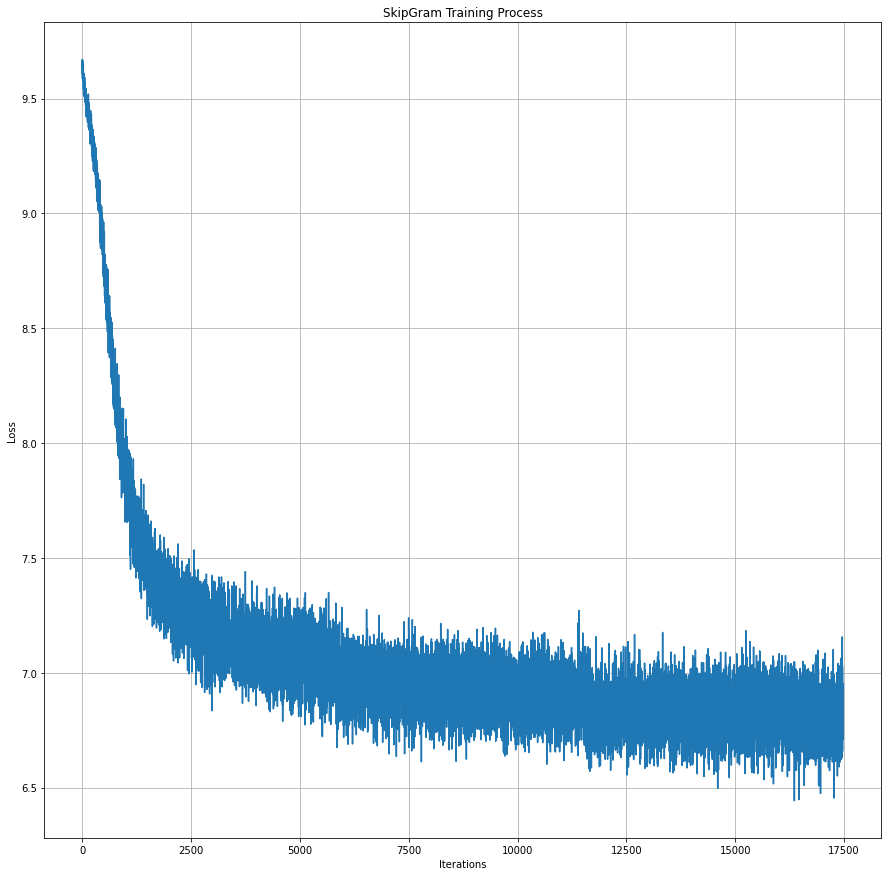

In [85]:
embedding_matrix_3 = train(embedding_dim=30, lr=0.001)

In [86]:
calculate_mse(embedding_matrix_3)

MSE: 0.7369679922096408


MSE увеличился относительно Эксперимента 2, качество ухудшилось.

## Эксперимент 4

Вернем learning rate обратно и возьмем контекст размером 3 вместо 2.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 3: 100%|██████████| 4174732/4174732 [04:11<00:00, 16593.88it/s, loss=7.04]


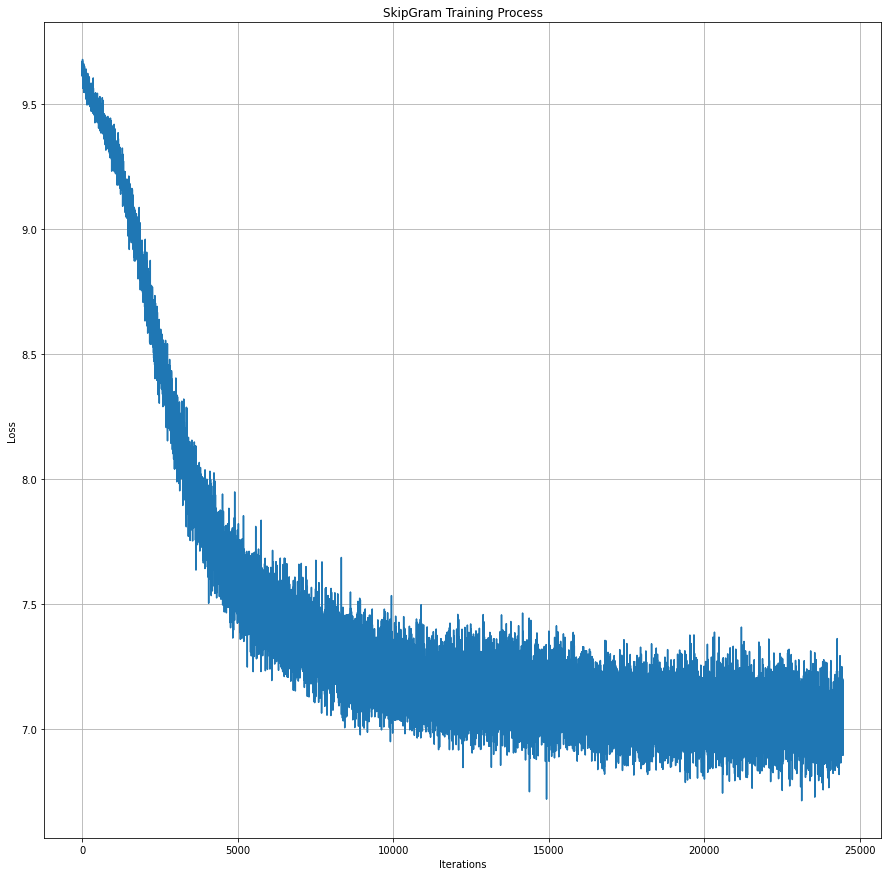

In [88]:
embedding_matrix_4 = train(window=3, embedding_dim=30)

In [89]:
calculate_mse(embedding_matrix_4)

MSE: 0.7207902391126585


Качество улучшилось еще больше!